# ОИАД. Лабораторная работа №2

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) $N \\% 5$
2) $N^2 \\% 5 + 5$
где $N$ - номер в списке

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

## 5. Выводы
Сделать вывод по каждому пункту

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [54]:
df = pd.read_csv("/content/students_simple.csv")
df.head()

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [55]:
N = 2
x = N % 5
y = (N ** 2) % 5 + 5

columns = df.columns
print(columns)

Index(['height', 'mass', 'income', 'iq', 'pages', 'age', 'bmi', 'work_exp',
       'friends', 'test_time'],
      dtype='object')


In [56]:
data = pd.DataFrame(
    {
        "N": np.arange(1, len(df) + 1),
        "x": df[df.columns[x]],
        "y": df[df.columns[y]]
    }
)
data.head()

,N,x,y
0,1,430,8.5
1,2,640,6.2
2,3,610,6.8
3,4,330,12.0
4,5,420,7.5


In [57]:
x = data["x"]
y = data["y"]
n = len(data)

sx = np.sign(x - x.mean())
sy = np.sign(y - y.mean())
fechner_r = np.corrcoef(sx, sy)[0,1]
pearson_r, _ = stats.pearsonr(x, y)
spearman_r, _ = stats.spearmanr(x, y)
kendall_tau, _ = stats.kendalltau(x, y)

def pearson_ci(r, n, alpha=0.05):
    z = np.arctanh(r)
    se = 1/np.sqrt(n-3)
    z_crit = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = z - z_crit*se, z + z_crit*se
    return np.tanh((lo_z, hi_z))
pearson_ci_lo, pearson_ci_hi = pearson_ci(pearson_r, n)

In [58]:
print(f"Fechner (sign-corr): {fechner_r:.4f}")
print(f"Pearson r: {pearson_r:.4f}, p={pearson_p:.4e}, 95% CI=({pearson_ci_lo:.4f}, {pearson_ci_hi:.4f})")
print(f"Spearman: {spearman_r:.4f}")
print(f"Kendall: {kendall_tau:.4f}")

Fechner (sign-corr): -0.4082
Pearson r: -0.5699, p=8.7082e-03, 95% CI=(-0.8085, -0.1703)
Spearman: -0.5392
Kendall: -0.4362


In [59]:
len(df)

20

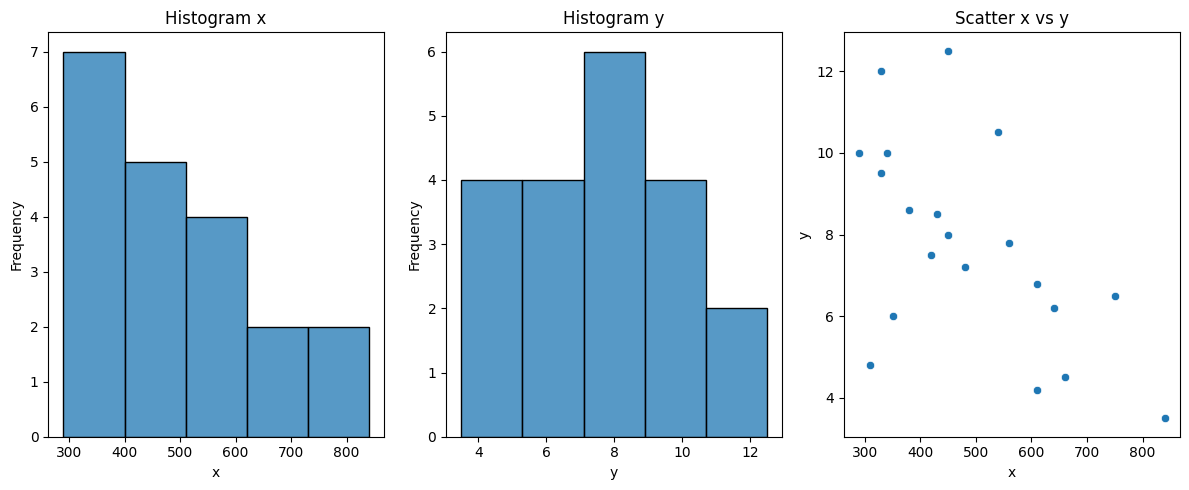

In [60]:
bins_count = 5

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
sns.histplot(x, bins=bins_count, kde=False)
plt.title("Histogram x")
plt.xlabel("x"); plt.ylabel("Frequency")

plt.subplot(1,3,2)
sns.histplot(y, bins=bins_count, kde=False)
plt.title("Histogram y")
plt.xlabel("y"); plt.ylabel("Frequency")

plt.subplot(1,3,3)
sns.scatterplot(x=x, y=y)
plt.title("Scatter x vs y")
plt.xlabel("x"); plt.ylabel("y")

plt.tight_layout()
plt.show()

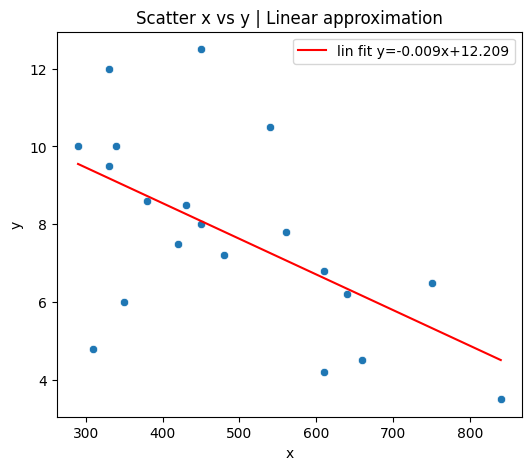

In [61]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=x, y=y)
m, b = np.polyfit(x, y, 1)
xs = np.linspace(x.min(), x.max(), 100)
plt.plot(xs, m*xs + b, color="red", label=f"lin fit y={m:.3f}x+{b:.3f}")
plt.legend()
plt.title("Scatter x vs y | Linear approximation")
plt.show()

In [62]:

X = (np.array(x)).reshape(-1,1)
Y = (np.array(y)).reshape(-1,1)

lin_model = LinearRegression().fit(X, Y)
w1_lin = lin_model.coef_[0,0]
w0_lin = lin_model.intercept_[0]

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X2 = poly2.fit_transform(X)

X2_for_fit = np.column_stack([X2[:,1], X2[:,0]])
X2_design = sm.add_constant(X2_for_fit)
res_q = sm.OLS(Y, X2_design).fit()
w0_quad = res_q.params[0]
w2_quad = res_q.params[1]
w1_quad = res_q.params[2]

eps = 1e-8
inv_x = 1/(X.flatten()+eps)
inv_model = LinearRegression().fit(inv_x.reshape(-1,1), Y)
w1_hyp = inv_model.coef_[0,0]
w0_hyp = inv_model.intercept_[0]

if np.all(Y > 0):
    lnY = np.log(Y.flatten())
    res_exp = sm.OLS(lnY, sm.add_constant(X)).fit()
    ln_w0 = res_exp.params[0]
    ln_w1 = res_exp.params[1]
    w0_exp = np.exp(ln_w0)
    w1_exp = np.exp(ln_w1)
else:
    w0_exp = np.nan; w1_exp = np.nan

In [63]:
print(f"Linear: y = {w1_lin:.4f} x + {w0_lin:.4f}")
print(f"Quadratic: y = {w2_quad:.4f} x^2 + {w1_quad:.4f} x + {w0_quad:.4f}")
print(f"Hyperbolic: y = {w1_hyp:.4f} / x + {w0_hyp:.4f}")
print(f"Exponential: w0 = {w0_exp:.4f}, w1 = {w1_exp:.4f}")

Linear: y = -0.0092 x + 12.2089
Quadratic: y = -0.0000 x^2 + 0.0097 x + 7.6017
Hyperbolic: y = 1832.3465 / x + 3.6149
Exponential: w0 = 14.1216, w1 = 0.9987


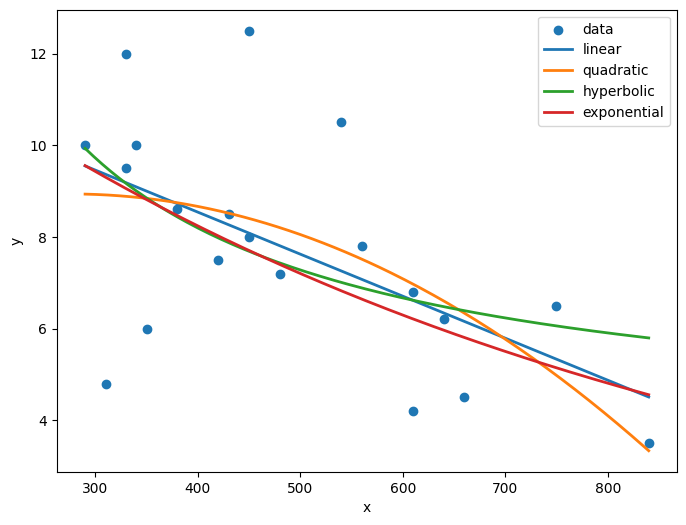

In [64]:
xs_plot = np.linspace(max(0.1, x.min()), x.max(), 200)

y_lin = w1_lin*xs_plot + w0_lin
y_quad = w2_quad*xs_plot**2 + w1_quad*xs_plot + w0_quad
y_hyp = w1_hyp/(xs_plot+eps) + w0_hyp
y_exp = w0_exp * (w1_exp**xs_plot)

plt.figure(figsize=(8,6))
plt.scatter(x, y, label="data")
plt.plot(xs_plot, y_lin, label="linear", linewidth=2)
plt.plot(xs_plot, y_quad, label="quadratic", linewidth=2)
plt.plot(xs_plot, y_hyp, label="hyperbolic", linewidth=2)
plt.plot(xs_plot, y_exp, label="exponential", linewidth=2)
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

x_arr = np.asarray(x).flatten()
y_arr = np.asarray(y).flatten()

eps = 1e-8
y_pred_lin  = w1_lin * x_arr + w0_lin
y_pred_quad = w2_quad * x_arr**2 + w1_quad * x_arr + w0_quad
y_pred_hyp  = w1_hyp / (x_arr + eps) + w0_hyp
y_pred_exp  = w0_exp * (w1_exp ** x_arr)

def losses(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

metrics = {
    "linear":    losses(y_arr, y_pred_lin),
    "quadratic": losses(y_arr, y_pred_quad),
    "hyperbolic":losses(y_arr, y_pred_hyp),
    "exponential": losses(y_arr, y_pred_exp)
}

results = []
for name, m in metrics.items():
    results.append((name, m["MSE"], m["RMSE"], m["MAE"]))
results_df = pd.DataFrame(results, columns=["model","MSE","RMSE","MAE"]).set_index("model")
print(results_df)

best_model = results_df["MSE"].idxmin()
worst_model = results_df["MSE"].idxmax()
print(f"\nBest model by MSE: {best_model} (MSE={results_df.loc[best_model,'MSE']:.6f})")
print(f"Worst model by MSE: {worst_model} (MSE={results_df.loc[worst_model,'MSE']:.6f})")

best_preds = {
    "linear": y_pred_lin,
    "quadratic": y_pred_quad,
    "hyperbolic": y_pred_hyp,
    "exponential": y_pred_exp
}[best_model]
worst_preds = {
    "linear": y_pred_lin,
    "quadratic": y_pred_quad,
    "hyperbolic": y_pred_hyp,
    "exponential": y_pred_exp
}[worst_model]


                  MSE      RMSE       MAE
model                                    
linear       4.083128  2.020675  1.446199
quadratic    3.905364  1.976199  1.478603
hyperbolic   4.579035  2.139868  1.516960
exponential  4.305486  2.074966  1.506723

Best model by MSE: quadratic (MSE=3.905364)
Worst model by MSE: hyperbolic (MSE=4.579035)


In [66]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from scipy import stats

x = np.asarray(x).flatten()
y = np.asarray(y).flatten()
n = len(y)
eps = 1e-8

def f_test_model_vs_constant_with_sklearn(X, y, log_target=False):
    if log_target:
        if np.any(y <= 0):
            return (np.nan, np.nan, np.nan, np.nan)
        y_used = np.log(y)
    else:
        y_used = y

    X_sm = sm.add_constant(X)
    mod = sm.OLS(y_used, X_sm).fit()
    ssr = np.sum((mod.fittedvalues - y_used.mean())**2)
    sse = np.sum((y_used - mod.fittedvalues)**2)
    df_model = int(mod.df_model)
    df_resid = int(mod.df_resid)
    if sse <= 0 or df_model <= 0 or df_resid <= 0:
        return (np.nan, np.nan, df_model, df_resid)
    F_model = (ssr / df_model) / (sse / df_resid)
    p_value = 1 - stats.f.cdf(F_model, df_model, df_resid)
    return (float(F_model), float(p_value), df_model, df_resid)

X_linear = x.reshape(-1,1)
X_quadratic = np.column_stack([x, x**2])
X_hyper = (1.0 / (x + eps)).reshape(-1,1)
X_exp = x.reshape(-1,1)

F_lin, p_lin, dfm_lin, dfr_lin = f_test_model_vs_constant_with_sklearn(X_linear, y, log_target=False)
F_quad, p_quad, dfm_quad, dfr_quad = f_test_model_vs_constant_with_sklearn(X_quadratic, y, log_target=False)
F_hyp, p_hyp, dfm_hyp, dfr_hyp = f_test_model_vs_constant_with_sklearn(X_hyper, y, log_target=False)
F_exp, p_exp, dfm_exp, dfr_exp = f_test_model_vs_constant_with_sklearn(X_exp, y, log_target=True)

results = pd.DataFrame([
    ("linear",    F_lin,  p_lin,  dfm_lin, dfr_lin),
    ("quadratic", F_quad, p_quad, dfm_quad, dfr_quad),
    ("hyperbolic",F_hyp,  p_hyp,  dfm_hyp, dfr_hyp),
    ("exponential",F_exp, p_exp, dfm_exp, dfr_exp)
], columns=["model","F_stat","p_value","df_model","df_resid"]).set_index("model")

print(results)
print("\nИнтерпретация: p_value < 0.05 означает, что модель статистически значимо лучше модели с константой.")


                F_stat   p_value  df_model  df_resid
model                                               
linear        8.657943  0.008708         1        18
quadratic     4.661474  0.024320         2        17
hyperbolic    5.770903  0.027299         1        18
exponential  10.222317  0.004993         1        18

Интерпретация: p_value < 0.05 означает, что модель статистически значимо лучше модели с константой.


### Выводы по анализу данных

Данные показывают устойчивую отрицательную связь между x и y: коэффициент Пирсона r = −0.5699 с p = 0.0087 говорит о статистически значимом умеренном отрицательном линейном тренде, ранговые корреляции (Spearman = −0.5392, Kendall = −0.4362) и знаковая корреляция Фехнера ≈ −0.408 подтверждают согласованный порядок уменьшения y при увеличении x; размер выборки — 20 наблюдений.  

Краткая интерпретация статистик согласуется друг с другом: связь не случайна и имеет направление «чем больше x, тем меньше y», но сила связи не экстремальна — есть разброс и нелинкие компоненты, которые видно на рассеянии и гистограммах.  

По аппроксимациям: получены параметры для четырёх типов моделей — линейной, квадратичной, гиперболической и экспоненциальной; численно они дают следующие качества подгонки по MSE: квадратичная модель — наилучшая (MSE ≈ 3.905), гиперболическая — наихудшая (MSE ≈ 4.579); линейная и экспоненциальная находятся между ними (MSE линейной ≈ 4.083, экспоненциальной ≈ 4.305).  

F‑тесты показывают, что все четыре модели объясняют значимую долю вариации по сравнению с константой: экспоненциальная модель дала самое сильное значение F и наименьший p (F ≈ 10.22, p ≈ 0.005), линейная тоже значима (F ≈ 8.66, p ≈ 0.0087), квадратичная и гиперболическая имеют p < 0.05, но менее выразительную статистическую силу по сравнению с экспонентой и линейной моделью.  

